This is a notebook to do the forecast for MeerKLASS using the new version of the lim code. 

In [1]:
# import packages
import SSLimPy.interface.sslimpy as sslimpy
from SSLimPy.cosmology.cosmology import cosmo_functions as cosmo_comp
import numpy as np
import astropy.units as u
import astropy.constants as cu
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns
import astropy

from scipy.special import legendre

import matplotlib.gridspec as gridspec
import matplotlib

from scipy.interpolate import interp1d

kitsune   = '#D9972F'
seiheki   = '#478384'
shuan     = '#740A00'
aonibi      = '#324356'
shion       = '#968ABD'

matplotlib.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"
colors = ['#9e1b1b','#6cb6c4',kitsune,'#a152d9','#0b3e45','#46b52b','#787575']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 2.

%matplotlib inline

### Power spectrum model

We are going to use the following model for the power spectrum. Considering only the auto power spectrum of HI 21cm, and assuming that we want to do a BAO analysis (and neglecting any shot noise), we have

$$P(k,\mu) = B\frac{1+\beta\mu^2}{1+(k\mu\sigma_{{\rm p}})^2}P_m(k)W(k)\,,$$
where $W(k)$ is the suppression by the beam, and $k$ and $\mu$ are affected by the AP effect as
$$ k^{\rm true} = \frac{k^{\rm meas}}{\alpha_\perp}\left[1+\left(\mu\right)^2\left((F_{\rm proj}^{(i)})^{-2}-1\right)	\right]^{1/2}\,, $$
$$ \mu^{\rm true} = \frac{\mu^{\rm meas}}{F_{\rm proj}^{(i)}}\left[1+\left(\mu\right)^2\left((F_{\rm proj}^{(i)})^{-2}-1\right)	\right]^{-1/2},$$ 
with $F_{\rm proj}=\alpha_\parallel/\alpha_\perp$ and we know
$$\alpha_\parallel = \frac{\left(Hr_{\rm d}\right)^{\rm fid}}{Hr_{\rm d}}\,,\qquad \alpha_\perp = \frac{D_M/r_{\rm d}}{\left(D_M/r_{\rm d}\right)^{\rm fid}} \,.$$ 

Note here that $P_m$ already includes the suppression on the BAO amplitude due to the nonlinear bulk velocities at large scales. 

The final data vector is the concatenation of the monopole and quadrupole of the power spectrum, which are computed as
$$P_\ell = \frac{2\ell+1}{2}\int{\rm d}\mu P(k,\mu) + \mathcal{D}_\ell(k)\,,$$
where $\mathcal{D}_\ell$ is a functional to marginalize over the broad (the smooth shape of the power spectrum). We follow the current DESI pipeline and use the implementation in the barry code which uses splines. More information can be found in the DESI BAO paper with galaxies and quasars. Note that this functional aims to marginalize over potential systematics (both theoretical and observations) affecting the smooth shape of the power spectrum, leaving the BAO feature as the only marker, which is a good thing because is the only one which is actually very robust. Therefore, we need a different functional for each multipole and patch on the sky (i.e., compute the Fisher matrix for each patch, marginalize over the coefficients of this functional, and combine all patches after that).

For the covariance, we assume a Gaussian covariance. In this case, there are 4 blocks (for the auto and cross of each multipole). Each block is diagonal

Assume we have a single patch and we consider only the auto for MeerKLASS. In such case, we have the following parameters:
$$\left\lbrace \alpha_\parallel,\,\alpha_\perp,\, B,\, \beta,\, \sigma_p,\,\sigma_v,\, \pmb{a},\, \mathcal{B} \right\rbrace\,,$$ where $B$ is equivalent to the degenerate uncertainties of the product of $\langle Tb\rangle\sigma_8$ and $\pmb{a}$ are the coefficients of $\mathcal{D}_\ell$, $\mathcal{B}$ accounts for the beam, and $\sigma_v$ is the velocity scale for the QNL BAO suppression.

### Compute power spectrum at the fiducial value of the parameters

General tools

In [2]:
# Tools

def nu_from_lambda(lam):
    return (cu.c/lam).to(u.MHz)

def lambda_from_nu(nu):
    return (cu.c/nu).to(u.um)

def plot_2d(covmat,index,center,ax,color1,color2,TwoSigma=True,filled=True,factors=None,alpha=[1,1],zorder=1):
    '''
    Paints 2d ellipses representing forecast constraints from the Fisher matrix. 
    Uses https://arxiv.org/pdf/0906.4123.pdf
    '''
    #Define the 2x2 covariance matrix from the covariance matrix obtained from the inverse of the Fisher
    matrix = covmat[np.ix_(index,index)]
    clr = [color1,color2]
    #Rescale the errors if needed
    if factors: 
        s1 = matrix[0,0]**0.5*factors[0]
        s2 = matrix[1,1]**0.5*factors[1]
        s12 = matrix[0,1]*factors[0]*factors[1]
        center[0] *= factors[0]
        center[1] *= factors[1]
    else:
        s1 = matrix[0,0]**0.5
        s2 = matrix[1,1]**0.5
        s12 = matrix[0,1]
        
    rho = s12/s1/s2
    #print 'correlation =', rho
    #1sigma and 2sigma Delta chi2
    Deltachi2 = 2.3
    TwoSigmaDeltachi2 = 6.17
    
    xpar = np.linspace(-4*s1,4*s1,64)
    ypar = np.linspace(-4*s2,4*s2,64)
    xi_grid, yi_grid = np.meshgrid(xpar,ypar)
    #Define contours (ellipses) corresponding to chi2
    chi2 = ((xi_grid/s1)**2+(yi_grid/s2)**2-2.*rho*(xi_grid/s1)*(yi_grid/s2))/(1-rho**2)
    
    #Paint the contours
    if filled:
        if TwoSigma:
            ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,TwoSigmaDeltachi2],colors=clr[1],alpha=alpha[1],zorder=zorder)
        ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,Deltachi2],colors=clr[0],alpha=alpha[0],zorder=zorder)
    if TwoSigma:
        ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[TwoSigmaDeltachi2],colors=clr[1],linewidths=1,alpha=alpha[0],zorder=zorder)
    ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[Deltachi2],colors=clr[0],linewidths=1,alpha=alpha[0],zorder=zorder)

    ax.scatter(center[0],center[1],marker='o',color='k',s=20,zorder=6,edgecolors='k',lw=1)
    return


MeerKLASS functions to get values

In [3]:
def get_kvec(Vsurvey):
    '''
    Get the kvector for a given survey volume 
    '''
    Vsurvey = Vsurvey.to(u.Mpc**3)
    kmin = 2*np.pi/Vsurvey**(1/3)
    kmax = 0.1/u.Mpc
    kvec_edge = np.arange(kmin.value,kmax.value,kmin.value)*kmin.unit
    kvec = 0.5*(kvec_edge[:-1]+kvec_edge[1:])
    return kvec

def get_volume(M,Omega_field,zc,dz):
    '''
    Get the probed volume as function of area, z_center (zc) and redshift bin width (dz)
    '''
    zmin,zmax = zc-0.5*dz,zc+0.5*dz
    Lside = M.comoving(zmax)-M.comoving(zmin)
    Stot = M.comoving(zc)**2*(Omega_field/(1.*u.rad**2)).decompose()
    return Lside*Stot

def THI_mean(z):
    '''
    Mean T_HI temperature
    '''
    return (0.0559+0.2324*z-0.024*z**2)*u.mK

def bHI_mean(z):
    '''
    mean HI bias
    '''
    return 0.67+0.18*z+0.05*z**2

def get_beam(zc,D):
    ''''
    Get the beam width as function of diameter, redshift
    '''
    nuHI = nu_from_lambda(21*u.cm)
    return (1.22*cu.c/nuHI*(1+zc)/D).decompose()*u.rad

def B_beam(k,mu,zc,beam,M):
    '''
    Beam smoothing
    '''
    return np.exp(-k[:,None]**2*(1-mu[None,:]**2)*(M.angdist(zc)*(1+zc)*beam/u.rad)**2/(16*np.log(2)))


Broadband functional computations

In [4]:
def prep_broadband(k,M,npoles=2):
    '''
    Prepares the spline for the broadband
    '''
    Delta = 2*np.pi/(147*u.Mpc)
    n_max = int((k[-1]-k[0])/Delta)+1
    # W3 is the Piecewise Cubic Spline (fourth-order) interpolation function
    x = np.fabs(np.array([k / Delta - (n - 1) for n in range(n_max)]))
    W3 = np.where(x <= 1, 4.0 - 6.0 * x**2 + 3.0 * x**3, np.where(x <= 2, (2.0 - x) ** 3, 0.0)) / 6.0
    # Store the W3 values in the broadband array
    poly_bb = np.zeros((n_max * npoles, npoles, len(k)))
    for i, pole in enumerate(range(npoles)):
        poly_bb[n_max * i : n_max * (i + 1), pole] = W3
    return n_max, poly_bb
            
def add_bb(pkpoles,coeffs,bb,n_max,npoles):
    '''
    adds the broadband spline to the Pk multipoles
    '''
    pkmuls = copy(pkpoles)
    count = 0
    for j,pole in enumerate(range(npoles)):
        for n,ip in enumerate(range(n_max)):
            if n_max == 3 and j == 1:
                count = 1
            else:
                count = 0
            pkmuls[j] += coeffs[npoles*j+n+count]*bb[npoles*j+n+count,pole,:]*pkpoles[0].unit
    return pkmuls

def Tsys(zc):
    '''
    Returns the effective system temperature as function of z
    '''
    nuObs = np.array([5.800000000000000000e+02,6.000000000000000000e+02, 6.500000000000000000e+02, 7.000000000000000000e+02, 
                      7.500000000000000000e+02, 8.000000000000000000e+02, 8.500000000000000000e+02, 9.000000000000000000e+02, 
                       9.500000000000000000e+02, 1.000000000000000000e+03])
    Tsys= np.array([3.145097253000000137e+01, 3.030244111000000018e+01, 2.793684247999999926e+01, 2.610862067000000053e+01, 
                   2.465761523999999838e+01, 2.347801079999999985e+01, 2.249790518000000006e+01, 2.166722859000000057e+01, 
                   2.095035455000000013e+01, 2.032144411000000161e+01])

    nuHI = nu_from_lambda(21*u.cm)
    nuHI_Obs = nuHI/(1+zc)

    fsys = 0.72
    
    Tsys_nu = interp1d(nuObs,Tsys)(nuHI_Obs)*u.K*fsys
    return Tsys_nu

Dummy call

In [5]:
cosmodict={"h":0.6774,
           "Omegam":0.31,
           "Omegab":0.05,
           "sigma8":0.82,
           "mnu":0.06,
           "ns":0.967}

In [6]:
settings = {"code":"class","TracerPowerSpectrum":"clustering","QNLpowerspectrum":False}

dummy = sslimpy.sslimpy(settings_dict=settings,
                           cosmopars=cosmodict)
M = cosmo_comp(cosmopars=cosmodict)

#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#


In [7]:
# set redshift and quantites for MeerKLASS
zc = 0.61
dz = 0.1
THI = THI_mean(zc)
bHI = bHI_mean(zc)
s8 = M.sigma8_of_z(zc)
Tbs8 = THI*bHI*s8
f = M.growth_rate(0.08/u.Mpc,zc,'clustering')
D = 13.5*u.m #Diameter of dish
beam = get_beam(zc,D)
npoles = 2
T_sys = Tsys(zc)
Omega_field = 7500*u.deg**2
beta = f/bHI

#derived from survey
V = get_volume(M,Omega_field,zc,dz)
kvec = get_kvec(V)
mu = np.linspace(-1,1,128)
nmax, bb = prep_broadband(kvec,M,npoles=npoles)

nuHI = nu_from_lambda(21*u.cm).to(u.GHz)
nuObs = nuHI/(1+zc)
Delta_nu = nuHI/(1+zc-dz) - nuHI/(1+zc+dz)

Now that we got everything, do the actual run

In [8]:
cosmodict={"h":0.6774,
           "Omegam":0.31,
           "Omegab":0.05,
           "sigma8":0.82,
           "mnu":0.06,
           "ns":0.967}

fidBAO_dict = {
    "alpha_par": 1,
    "alpha_perp": 1,
    "sigmap": 7 * u.Mpc,
    "sigmav": 5 * u.Mpc,
    "bmean": bHI,
    "Tmean": THI.to(u.K),
    "Pshot": 0.*u.Mpc**3*u.K**2,
    "beta":beta
    }

settings = {"code":"class",
            "do_RSD" : True,
            "nonlinearRSD" : True,
            "FoG_damp" : "ISTF_like",
            "halo_model_PS" : False,
            "Smooth_window" :False,
            "Smooth_resolution":True,
            "output" : ["Power spectrum","Covariance"],
            "TracerPowerSpectrum":"clustering",
            "kmin": (kvec[0]-np.diff(kvec)[0]/2),
            "kmax": (kvec[-1]+np.diff(kvec)[0]/2),
            "nk": len(kvec),
            "QNLpowerspectrum": True}

settings2 = copy(settings)
settings2["QNLpowerspectrum"] = False

obspars = {'Tsys_NEFD' : T_sys,
  'Nfeeds' : 1,
  'beam_FWHM' : beam.to(u.arcmin),
  'nu': nuHI,
  'nuObs': nuObs,
  'Delta_nu' : Delta_nu,
  'dnu' : 0*u.MHz,
  'tobs' : 1300*u.h,
  'nD' : 60,
  'Omega_field' : Omega_field,
  'Nfield' : 1,
  'N_FG_par' : 1,
  'N_FG_perp' : 1,
  'do_FG_wedge' : False,
  'a_FG' : 0.,
  'b_FG' : 0.}

In [9]:
SSLIMPY = sslimpy.sslimpy(settings_dict=settings,
                           cosmopars=cosmodict,
                           BAOpars=fidBAO_dict,
                         obspars_dict=obspars,
                         astropars=dict())



#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#


In [10]:
Fiducial_output = SSLIMPY.compute(cosmopars=cosmodict,
                                  astropars=dict(),
                                  BAOpars=fidBAO_dict,
                                  obspars=obspars,
                                  output=["Power spectrum",
                                          "Covariance"])


Done!


In [11]:
# get the power spectrum multipoles and the k vector
Ps_fid = Fiducial_output["Power spectrum"]
k = Ps_fid.k
PfidMoments = (np.array([Ps_fid.Pk_0bs, Ps_fid.Pk_2bs]) * Ps_fid.Pk_0bs.unit).to(u.mK**2*u.Mpc**3)

In [12]:
print(PfidMoments.shape)
print('[npol,nk,nz]')

(2, 23, 1)
[npol,nk,nz]


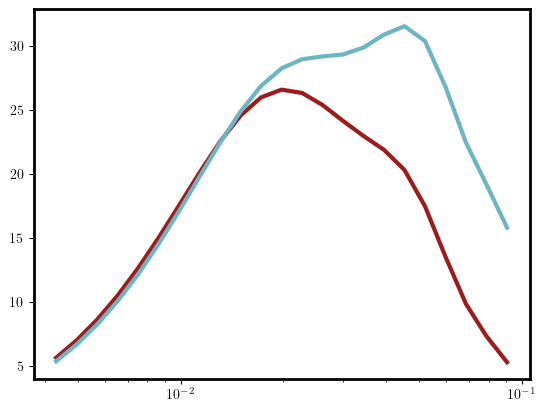

In [13]:
plt.semilogx(k,k*PfidMoments[0,:,0])
plt.semilogx(k,k*PfidMoments[1,:,0])


### Derivatives

Remember, the free parameters are:

$$\left\lbrace \alpha_\parallel,\,\alpha_\perp,\, B,\, \beta,\, \sigma_v,\, \sigma_p,\, \pmb{a},\, \mathcal{B} \right\rbrace\,,$$

In [14]:
derivative_dic = dict()
eps = 1e-2
BAOpars = ["alpha_par", "alpha_perp","beta","sigmap","sigmav"]
obsparschange = ["beam_FWHM"]
otherpars = ["B"]


In [15]:

for param in BAOpars:
    BAO_var_dict = copy(fidBAO_dict)
    
    # do step
    BAO_var_dict[param] = fidBAO_dict[param] * (1 + eps)
    # compute power spectrum
    Pobs = SSLIMPY.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=BAO_var_dict,
                           obspars=obspars
                           )["Power spectrum"]
    dPp = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    BAO_var_dict[param] = fidBAO_dict[param] * (1 - eps)
    Pobs = SSLIMPY.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=BAO_var_dict,
                           obspars=obspars,
                           )["Power spectrum"]
    dPm = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    derivative_dic[param] = ((dPp - dPm) / (2 * eps * fidBAO_dict[param])).value

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


In [16]:
B = (bHI*THI*cosmodict["sigma8"])**2
derivative_dic["B"] =  (PfidMoments/B).value




In [17]:

for param in obsparschange:
    obs_var_dict = copy(obspars)
    
    # do step
    obs_var_dict[param] = obspars[param] * (1 + eps)
    # compute power spectrum
    Pobs = SSLIMPY.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=fidBAO_dict,
                           obspars=obs_var_dict
                           )["Power spectrum"]
    dPp = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    obs_var_dict[param] = obspars[param] * (1 - eps)
    Pobs = SSLIMPY.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=fidBAO_dict,
                           obspars=obs_var_dict,
                           )["Power spectrum"]
    dPm = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    derivative_dic[param] = ((dPp - dPm) / (2 * eps * obspars[param])).value

Done!
Done!


In [18]:
#Broadband
coeff_set = [0]*nmax*npoles
bb_pars = ['a'+str(i+1) for i in range(len(coeff_set))]
pkpoles = [Pobs.Pk_0bs[:,0],Pobs.Pk_2bs[:,0]]
for p in range(len(coeff_set)):
    coeff_set[p] = eps
    pk0_plus, pk2_plus = add_bb(pkpoles,coeff_set,bb,nmax,npoles)
    dPp = np.array([pk0_plus, pk2_plus])

    coeff_set[p] = -eps
    pk0_minus, pk2_minus = add_bb(pkpoles,coeff_set,bb,nmax,npoles)
    dPm = np.array([pk0_minus, pk2_minus])

    derivative_dic[bb_pars[p]] = (dPp - dPm) / (2 * eps)

Check the derivatives we have done!

In [19]:
print(derivative_dic.keys())

dict_keys(['alpha_par', 'alpha_perp', 'beta', 'sigmap', 'sigmav', 'B', 'beam_FWHM', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6'])


### Fisher

In [20]:
allpars = np.array([*BAOpars, *otherpars, *obsparschange, *bb_pars])
no_bbpars = np.array([*BAOpars, *otherpars, *obsparschange])
print(allpars)
print(no_bbpars)

['alpha_par' 'alpha_perp' 'beta' 'sigmap' 'sigmav' 'B' 'beam_FWHM' 'a1'
 'a2' 'a3' 'a4' 'a5' 'a6']
['alpha_par' 'alpha_perp' 'beta' 'sigmap' 'sigmav' 'B' 'beam_FWHM']


Get the covariance. By default, built as [nk,npol,npol,nz] 

In [21]:
npol = 2
nk = len(k)
nz = 1

In [22]:
Cov = Fiducial_output["Covariance"].gaussian_cov()
invCov = np.empty((nk,npol,npol,nz), dtype=u.Quantity)
z = Pobs.z
for iz in range(len(z)):
    invCov[:,:,:,iz] = np.linalg.inv(Cov[:,:npol,:npol,iz])
invCov = invCov #/Cov.unit

Get the Fisher matrix with all parameters

In [23]:
Fisher_all = np.empty((*allpars.shape,*allpars.shape))
for i, p1 in enumerate(allpars):
    for j, p2 in enumerate(allpars):
        # The index for k is k, ell is i, ell' is j
        # Covaraiance has indixes k, i, j
        # The derives have indixes i/j, k
        # At the end every index is summed over
        Fij = np.sum(
            np.einsum(
                "ik...,kij...,jk...",
                derivative_dic[p1], 
                invCov,
                derivative_dic[p2],
            )
        )
        Fisher_all[i,j] = Fij

Just to increase clarity, get a different one without the broadband parameters

In [24]:
Fisher_nobb = np.empty((*no_bbpars.shape,*no_bbpars.shape))
for i, p1 in enumerate(no_bbpars):
    for j, p2 in enumerate(no_bbpars):
        # The index for k is k, ell is i, ell' is j
        # Covaraiance has indixes k, i, j
        # The derives have indixes i/j, k
        # At the end every index is summed over
        Fij = np.sum(
            np.einsum(
                "ik...,kij...,jk...",
                derivative_dic[p1], 
                invCov,
                derivative_dic[p2],
            )
        )
        Fisher_nobb[i,j] = Fij

#### Do the same for the case in which we're not considering the bulk nonlinear suppression of BAO and without broadband marginalization

In [25]:
SSLIMPY_linear = sslimpy.sslimpy(settings_dict=settings2,
                           cosmopars=cosmodict,
                           BAOpars=fidBAO_dict,
                         obspars_dict=obspars,
                         astropars=dict())

Linear_output = SSLIMPY_linear.compute(cosmopars=cosmodict,
                                  astropars=dict(),
                                  BAOpars=fidBAO_dict,
                                  obspars=obspars,
                                  output=["Power spectrum",
                                          "Covariance"])
# get the power spectrum multipoles and the k vector
Ps_linear = Linear_output["Power spectrum"]
k = Ps_linear.k
PlinMoments = (np.array([Ps_linear.Pk_0bs, Ps_linear.Pk_2bs]) * Ps_linear.Pk_0bs.unit).to(u.mK**2*u.Mpc**3)

#--------------------------------------------------#

  SSSSS   SSSSS  L       i            PPPP   y    y 
 S     S S     S L            m   m   P    P y   y  
 S       S       L     iii   m m m m  P    P  y y   
  SSSSS   SSSSS  L       i   m  m  m  PPPP     y    
       S       S L       i   m     m  P        y    
 S     S S     S L       i   m     m  P       y     
  SSSSS   SSSSS  LLLLL iiiii m     m  P      y      

#--------------------------------------------------#
Done!


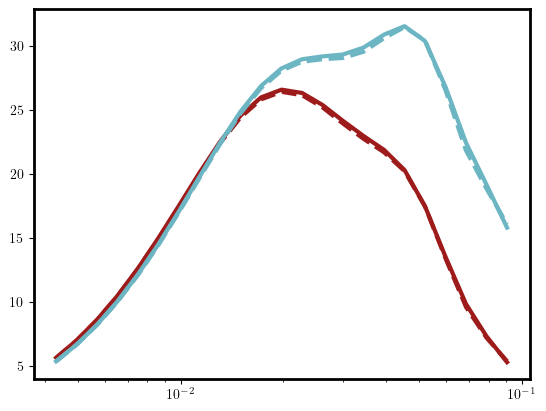

In [26]:
plt.semilogx(k,k*PfidMoments[0,:,0])
plt.semilogx(k,k*PlinMoments[0,:,0],c=colors[0],ls='--')
plt.semilogx(k,k*PfidMoments[1,:,0])
plt.semilogx(k,k*PlinMoments[1,:,0],c=colors[1],ls='--')
#plt.semilogx(k,k*SSLIMPY.fiducialcosmo.matpow(k,0.61))

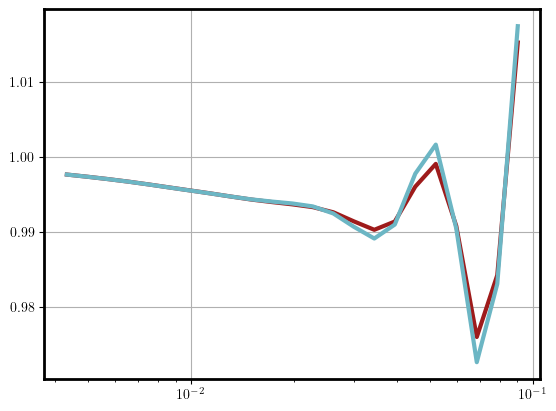

In [27]:
plt.semilogx(k,PlinMoments[0,:,0]/PfidMoments[0,:,0])
plt.semilogx(k,PlinMoments[1,:,0]/PfidMoments[1,:,0])
plt.grid()
#plt.semilogx(k,k*SSLIMPY.fiducialcosmo.matpow(k,0.61))

In [28]:
lin_derivative_dic = dict()
eps = 1e-2
BAOpars = ["alpha_par", "alpha_perp","beta","sigmap"]
obsparschange = ["beam_FWHM"]
otherpars = ["B"]


In [29]:

for param in BAOpars:
    BAO_var_dict = copy(fidBAO_dict)
    
    # do step
    BAO_var_dict[param] = fidBAO_dict[param] * (1 + eps)
    # compute power spectrum
    Pobs = SSLIMPY_linear.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=BAO_var_dict,
                           obspars=obspars
                           )["Power spectrum"]
    dPp = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    BAO_var_dict[param] = fidBAO_dict[param] * (1 - eps)
    Pobs = SSLIMPY_linear.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=BAO_var_dict,
                           obspars=obspars,
                           )["Power spectrum"]
    dPm = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    lin_derivative_dic[param] = ((dPp - dPm) / (2 * eps * fidBAO_dict[param])).value

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


In [30]:
B = (bHI*THI*cosmodict["sigma8"])**2
lin_derivative_dic["B"] =  (PlinMoments/B).value




In [31]:

for param in obsparschange:
    obs_var_dict = copy(obspars)
    
    # do step
    obs_var_dict[param] = obspars[param] * (1 + eps)
    # compute power spectrum
    Pobs = SSLIMPY_linear.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=fidBAO_dict,
                           obspars=obs_var_dict
                           )["Power spectrum"]
    dPp = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    obs_var_dict[param] = obspars[param] * (1 - eps)
    Pobs = SSLIMPY_linear.compute(cosmopars=cosmodict,
                           astropars=dict(),
                           BAOpars=fidBAO_dict,
                           obspars=obs_var_dict,
                           )["Power spectrum"]
    dPm = np.array([Pobs.Pk_0bs, Pobs.Pk_2bs]) * Pobs.Pk_0bs.unit

    lin_derivative_dic[param] = ((dPp - dPm) / (2 * eps * obspars[param])).value

Done!
Done!


In [32]:
no_bbpars = np.array([*BAOpars, *otherpars, *obsparschange])
print(no_bbpars)

['alpha_par' 'alpha_perp' 'beta' 'sigmap' 'B' 'beam_FWHM']


In [33]:
linCov = Linear_output["Covariance"].gaussian_cov()
lininvCov = np.empty((nk,npol,npol,nz), dtype=u.Quantity)
z = Pobs.z
for iz in range(len(z)):
    lininvCov[:,:,:,iz] = np.linalg.inv(linCov[:,:npol,:npol,iz])
lininvCov = lininvCov #/Cov.unit

In [34]:
linFisher_nobb = np.empty((*no_bbpars.shape,*no_bbpars.shape))
for i, p1 in enumerate(no_bbpars):
    for j, p2 in enumerate(no_bbpars):
        # The index for k is k, ell is i, ell' is j
        # Covaraiance has indixes k, i, j
        # The derives have indixes i/j, k
        # At the end every index is summed over
        Fij = np.sum(
            np.einsum(
                "ik...,kij...,jk...",
                lin_derivative_dic[p1], 
                lininvCov,
                lin_derivative_dic[p2],
            )
        )
        linFisher_nobb[i,j] = Fij

### Plot constraints

Marginalize over all parameters but $\alpha_\parallel$ and $\alpha_\perp$. Have another case also including $\beta$

In [35]:
Covpar_all = np.linalg.inv(Fisher_all)
Covpar_nobb = np.linalg.inv(Fisher_nobb)
linCovpar_nobb = np.linalg.inv(linFisher_nobb)

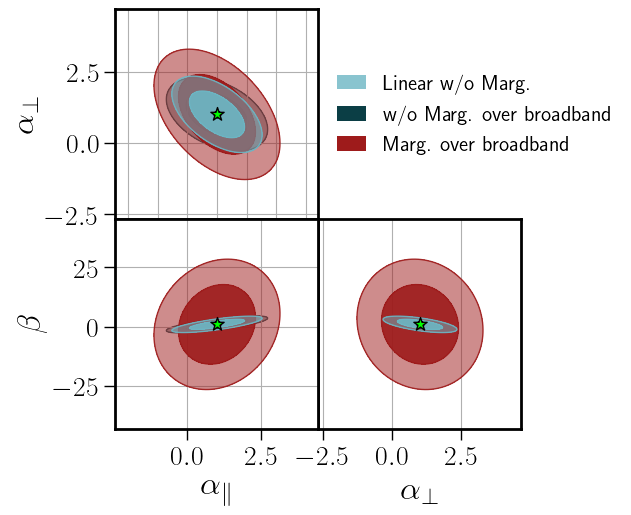

In [44]:
names = [r'$\alpha_\parallel$',r'$\alpha_\perp$',r'$\beta$']
NPAR = 3
fiducial_set_vals = [1,1,beta]

fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(NPAR, NPAR,wspace=0,hspace=0,top=0.97,left=0.1,bottom=0.07,right=0.97)

for i in range(NPAR-1)[::-1]:
    for j in range(i,NPAR-1):
        ax = plt.subplot(gs[j,i])
        #ax.locator_params(nbins=4,tight=True)
        center = np.array([fiducial_set_vals[i],fiducial_set_vals[j+1]])
        plot_2d(Covpar_nobb,[i,j+1],center,ax,color1=colors[4],color2=colors[4],filled=True,TwoSigma=True,zorder=1,alpha=[.7,0.4])
        plot_2d(Covpar_all,[i,j+1],center,ax,color1=colors[0],color2=colors[0],filled=True,TwoSigma=True,zorder=2,alpha=[.9,0.5])
        plot_2d(linCovpar_nobb,[i,j+1],center,ax,color1=colors[1],color2=colors[1],filled=True,TwoSigma=True,zorder=3,alpha=[.9,0.5])

        ax.scatter(center[0],center[1],marker='*',s=100,color='lime',edgecolors='k',zorder=10)
        ax.grid()
        if j+1 == NPAR-1:
            ax.set_xlabel(names[i],fontsize=24)
            ax.tick_params(axis='both',width=1,length=8,labelsize=20)
        if i == 0:
            ax.set_ylabel(names[j+1],fontsize=24)
            ax.tick_params(axis='both',width=1,length=8,labelsize=20)
            if j + 1 < NPAR-1:
                ax.tick_params(axis='x',width=1,length=8,labelsize=0)
        else:
            ax.set_yticks([])

ax = plt.subplot(gs[0,1])
ax.axis('off')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)

#ax = plt.subplot(gs[1,2])
proxy = [plt.Rectangle((0,0),1,1,fc = colors[1],alpha=0.8),plt.Rectangle((0,0),1,1,fc = colors[4],alpha=1),plt.Rectangle((0,0),1,1,fc = colors[0],alpha=1)]
ax.legend(proxy, [ r'Linear w/o Marg.',r'w/o Marg. over broadband',r'Marg. over broadband'],
          handlelength=1.4,frameon=False, fontsize=15,
         loc='center left')
ax.axis('off')

plt.show()

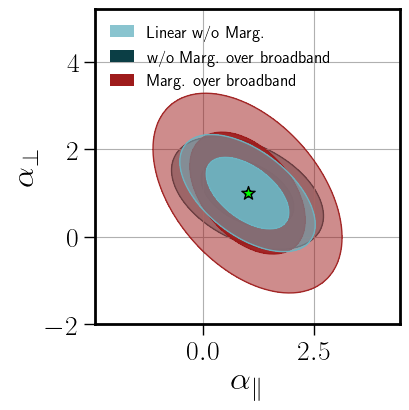

In [48]:
names = [r'$\alpha_\parallel$',r'$\alpha_\perp$',r'$\beta$']
NPAR = 2
fiducial_set_vals = [1,1,beta]

fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(NPAR, NPAR,wspace=0,hspace=0,top=0.97,left=0.1,bottom=0.07,right=0.97)

for i in range(NPAR-1)[::-1]:
    for j in range(i,NPAR-1):
        ax = plt.subplot(gs[j,i])
        #ax.locator_params(nbins=4,tight=True)
        center = np.array([fiducial_set_vals[i],fiducial_set_vals[j+1]])
        plot_2d(Covpar_nobb,[i,j+1],center,ax,color1=colors[4],color2=colors[4],filled=True,TwoSigma=True,zorder=1,alpha=[.7,0.4])
        plot_2d(Covpar_all,[i,j+1],center,ax,color1=colors[0],color2=colors[0],filled=True,TwoSigma=True,zorder=2,alpha=[.9,0.5])
        plot_2d(linCovpar_nobb,[i,j+1],center,ax,color1=colors[1],color2=colors[1],filled=True,TwoSigma=True,zorder=3,alpha=[.9,0.5])

        ax.scatter(center[0],center[1],marker='*',s=100,color='lime',edgecolors='k',zorder=10)
        ax.grid()
        if j+1 == NPAR-1:
            ax.set_xlabel(names[i],fontsize=24)
            ax.tick_params(axis='both',width=1,length=8,labelsize=20)
        if i == 0:
            ax.set_ylabel(names[j+1],fontsize=24)
            ax.tick_params(axis='both',width=1,length=8,labelsize=20)
            if j + 1 < NPAR-1:
                ax.tick_params(axis='x',width=1,length=8,labelsize=0)
        else:
            ax.set_yticks([])

proxy = [plt.Rectangle((0,0),1,1,fc = colors[1],alpha=0.8),plt.Rectangle((0,0),1,1,fc = colors[4],alpha=1),plt.Rectangle((0,0),1,1,fc = colors[0],alpha=1)]
ax.legend(proxy, [ r'Linear w/o Marg.',r'w/o Marg. over broadband',r'Marg. over broadband'],
          handlelength=1.4,frameon=False, fontsize=12,
         loc='upper left')
ax.set_ylim(-2,5.2)

plt.show()